In [10]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import scipy
import os
from torch.utils.data import Dataset, DataLoader, random_split

In [11]:
def create_snips(data_file, im_len, stride_len):
    '''takes the matlab file for a patient and creates images of the ecog data for training/testing. We have a 2D array made up of 
    electrode voltage vs time. This single, long signal needs to chopped up into smaller peices to create the desired dataset of 'images'
    args:
        data_file: matlab file for a patient
        i_len (int): length of each image (in ms)
        stride_len (int): length of stride (in ms)
    returns: 
        image_data (list): list of (image, label) pairs. image (2D array) -->electrode num voltages vs time, label (2D array) --> joystick coordinates vs time '''
    data = scipy.io.loadmat(data_file)
    array = data['data'].astype(np.float32)
    
#     # filter ecog
#     lowcut = 0.15
#     highcut = 200
#     order = 4
#     nyquistFreq = 1000 
#     # The Nyquist frequency is the highest frequency that equipment of a given sample rate can reliably measure, 
#     # one-half the given sample rate.

#     low  = lowcut / nyquistFreq
#     high = highcut / nyquistFreq

#     b, a = scipy.signal.butter(order, [low, high], btype='bandpass')
#     ch_num = array.shape[1]
#     array = np.zeros_like(array)
#     for i in range(ch_num):
#         array[:,i] = scipy.signal.filtfilt(b, a, array[:, i]) 
    
    
    indices = [(i, i+im_len) for i in list(range(0, array.shape[0] - im_len +1, stride_len))]
    cut_signals = [array[i[0]:i[1], :] for i in indices]
    assert len(data['CursorPosX']) == len(data['CursorPosY'])
    l_max = max(np.max(data['CursorPosX']), np.max(data['CursorPosY']))
    t_sample = [i+im_len-1 for i in list(range(0, len(data['CursorPosX']) - im_len +1, stride_len))]
    
    trajectory = [[data['CursorPosX'][i,0].astype(np.float16)/l_max, data['CursorPosY'][i,0].astype(np.float16)/l_max] for i in t_sample]
    # cut_signals.shape = (num_images, im_len, num_electrodes)
    return [(cut_signals[i].T, trajectory[i]) for i in range(len(cut_signals))]


In [12]:
# Load data
dataDir = r'/orange/physics-dept/an.kandala/Neuromatch_project/Joystick_tracking/joystick_track/data'
files = os.listdir(dataDir)
# load the data for the first patient
data= scipy.io.loadmat(os.path.join(dataDir, files[0]))
# path_orange = r'/Users/yiting/Documents/NMA_DL/Project/Movement_BCI/joystick_track/'

In [13]:
files[0]

'fp_joystick.mat'

In [14]:
class EEGNet(nn.Module):
    def __init__(self, num_electrodes, im_len):
        super(EEGNet, self).__init__()
        # Layer 1
        self.K1 = 16 #num of kernels
        self.K1_size = (num_electrodes, 1) #size of kernels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.K1, kernel_size=self.K1_size, padding = 0) #K1 kernels in the first layer, 
                                                            # each being Cx1 [1d convolution that combines the channel activity across all times into one number]
        self.batchnorm1 = nn.BatchNorm2d(self.K1, False)
        
        # Layer 2
        self.pad2_x = [0, 0]
        self.pad2_y = [0, 0]
        #kernels for layer 2
        self.K2 = 4
        self.K2_size = (3, 3)
        self.padding1 = nn.ZeroPad2d((self.pad2_x[0], self.pad2_x[1], self.pad2_y[0], self.pad2_y[1]))
        self.conv2 = nn.Conv2d(1, self.K2, self.K2_size)
        self.batchnorm2 = nn.BatchNorm2d(self.K2, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        
        # Layer 3
        self.pad3_x = [0, 0]
        self.pad3_y = [0, 0]
        #kernels for layer 2
        self.K3 = 4
        self.K3_size = (2, 2)

        self.padding2 = nn.ZeroPad2d((self.pad3_x[0], self.pad3_x[1], self.pad3_y[0], self.pad3_y[1]))
        self.conv3 = nn.Conv2d(self.K2, self.K3, self.K3_size)
        self.batchnorm3 = nn.BatchNorm2d(self.K3, False)
        self.pooling3 = nn.MaxPool2d((2, 4))
        self.final_layer_size = 0
        
    def forward(self, x):
        def forward_conv(self, x):
            # print('shape before forward pass', x.shape)
            # Layer 1
            x = F.elu(self.conv1(x))
            x = self.batchnorm1(x)
            x = F.dropout(x, 0.5)
            x = x.permute(0, 2, 1, 3)
            # Layer 2
            x = self.padding1(x)
            x = F.elu(self.conv2(x))
            x = self.batchnorm2(x)
            x = F.dropout(x, 0.5)
            x = self.pooling2(x)
            
            # Layer 3
            x = self.padding2(x)
            x = F.elu(self.conv3(x))
            x = self.batchnorm3(x)
            x = F.dropout(x, 0.5)
            x = self.pooling3(x)
            return x
            #need to compute the dimension of the input of the FC layer
        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data
        x = forward_conv(self, x)
        if self.final_layer_size == 0:
            self.final_layer_size = torch.numel(forward_conv(self, torch.zeros(1, 1, num_electrodes, im_len)))
            self.fc1 = nn.Linear(self.final_layer_size, 2)
        x = x.reshape(-1, self.final_layer_size)
        x = F.relu(self.fc1(x))
#         x = F.sigmoid(self.fc1(x))
        return x    
    

In [15]:
class CustomDataset(Dataset):
    def __init__(self):
        # Load or initialize your data
        self.data = [snip[0] for snip in snipped_data] # This could be a list of images, texts, etc.
        self.labels = [snip[1] for snip in snipped_data] # Only for supervised tasks

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]  # Only for supervised tasks
        return sample, label

In [16]:
#screen refresh rate ~ 20Htz. So stride > 50ms.
im_len = 1000
stride_len = 100
snipped_data = create_snips(os.path.join(dataDir, files[0]), im_len, stride_len)

dataset = CustomDataset()
#create testing and training sets:
per_train = 0.8 #percent of data to use for training
train_size = int(per_train * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
num_electrodes = len(snipped_data[0][0])


In [17]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
net = EEGNet(num_electrodes, im_len).cpu()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())
# epoch_size = 50

In [18]:
def eval(data, net, criterion):
    #computes the forward pass and loss of the loaded_data
    inputs = data[0]
    labels = data[1]  # Unpack the inputs and labels from the data loader
    l = torch.cat((labels[0], labels[1]))
    l = l.reshape(len(labels[0]), 2)
    # forward + backward + optimize
    outputs = net(inputs.unsqueeze(1))
    #training loss
    loss = criterion(outputs, l)
    return loss
train_loss_all = []
test_loss_all = []
for epoch in range(10):
    print("\nEpoch -", epoch)
    
    running_loss = 0.0
    train_loss_epoch = []
    test_loss_epoch = []
#     print('num batches', len(train_loader))
    for i, data in enumerate(train_loader, 0):  # Use the train_loader for data loading
        optimizer.zero_grad()
#         print(type(data))
        train_loss = eval(data, net, criterion)
        train_loss.backward()
        optimizer.step()
        running_loss += train_loss.item()  # Use loss.item() to get the scalar value of the loss

        #test loss
        test_loss = 0.0
        for i, data in enumerate(test_loader, 0):
            test_loss += eval(data, net, criterion).item()
        test_loss /= len(test_loader)
#         print('Batch number: ', i, 'train_Loss:', train_loss.item(), 'test_Loss:', test_loss)
        train_loss_epoch.append(train_loss.item())
        test_loss_epoch.append(test_loss)
#     print("Epoch {} - Loss: {:.4f}".format(epoch, running_loss))
    train_loss_all.append(np.mean(train_loss_epoch))
    test_loss_all.append(np.mean(test_loss_epoch))



Epoch - 0

Epoch - 1

Epoch - 2

Epoch - 3

Epoch - 4

Epoch - 5

Epoch - 6

Epoch - 7

Epoch - 8

Epoch - 9


Average difference between predicted and actual labels:  0.7549543
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8441115, 0.9378868, 0.0, 0.0, 0.0, 0.0, 0.0, 0.97769016, 1.0890661, 0.0, 0.0, 0.0, 0.06484166, 0.0, 0.0, 0.0, 0.0, 0.0, 0.29368314, 0.0, 0.0, 0.0, 0.0, 0.0, 0.41786313, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.39471713, 0.0, 0.0, 0.0, 0.0, 0.0, 0.572646, 0.98352545, 0.056829683, 0.0, 0.0, 0.0, 0.3332081, 0.0, 0.9996015, 0.0, 0.0, 0.0, 1.0261849, 0.0, 0.0, 0.66202044, 0.29329535, 0.0, 1.0691123, 0.25577763, 0.0, 0.0, 0.0, 0.0, 0.3731859, 0.0, 0.0, 0.1675882, 0.37633914, 1.8145128, 0.0, 0.0, 0.0, 0.0, 0.4885607, 0.0, 0.0, 0.0, 0.34947434, 0.7058134, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.69881094, 0.0, 0.0, 0.35524732, 0.6239192, 0.0, 0.0, 0.65046173]


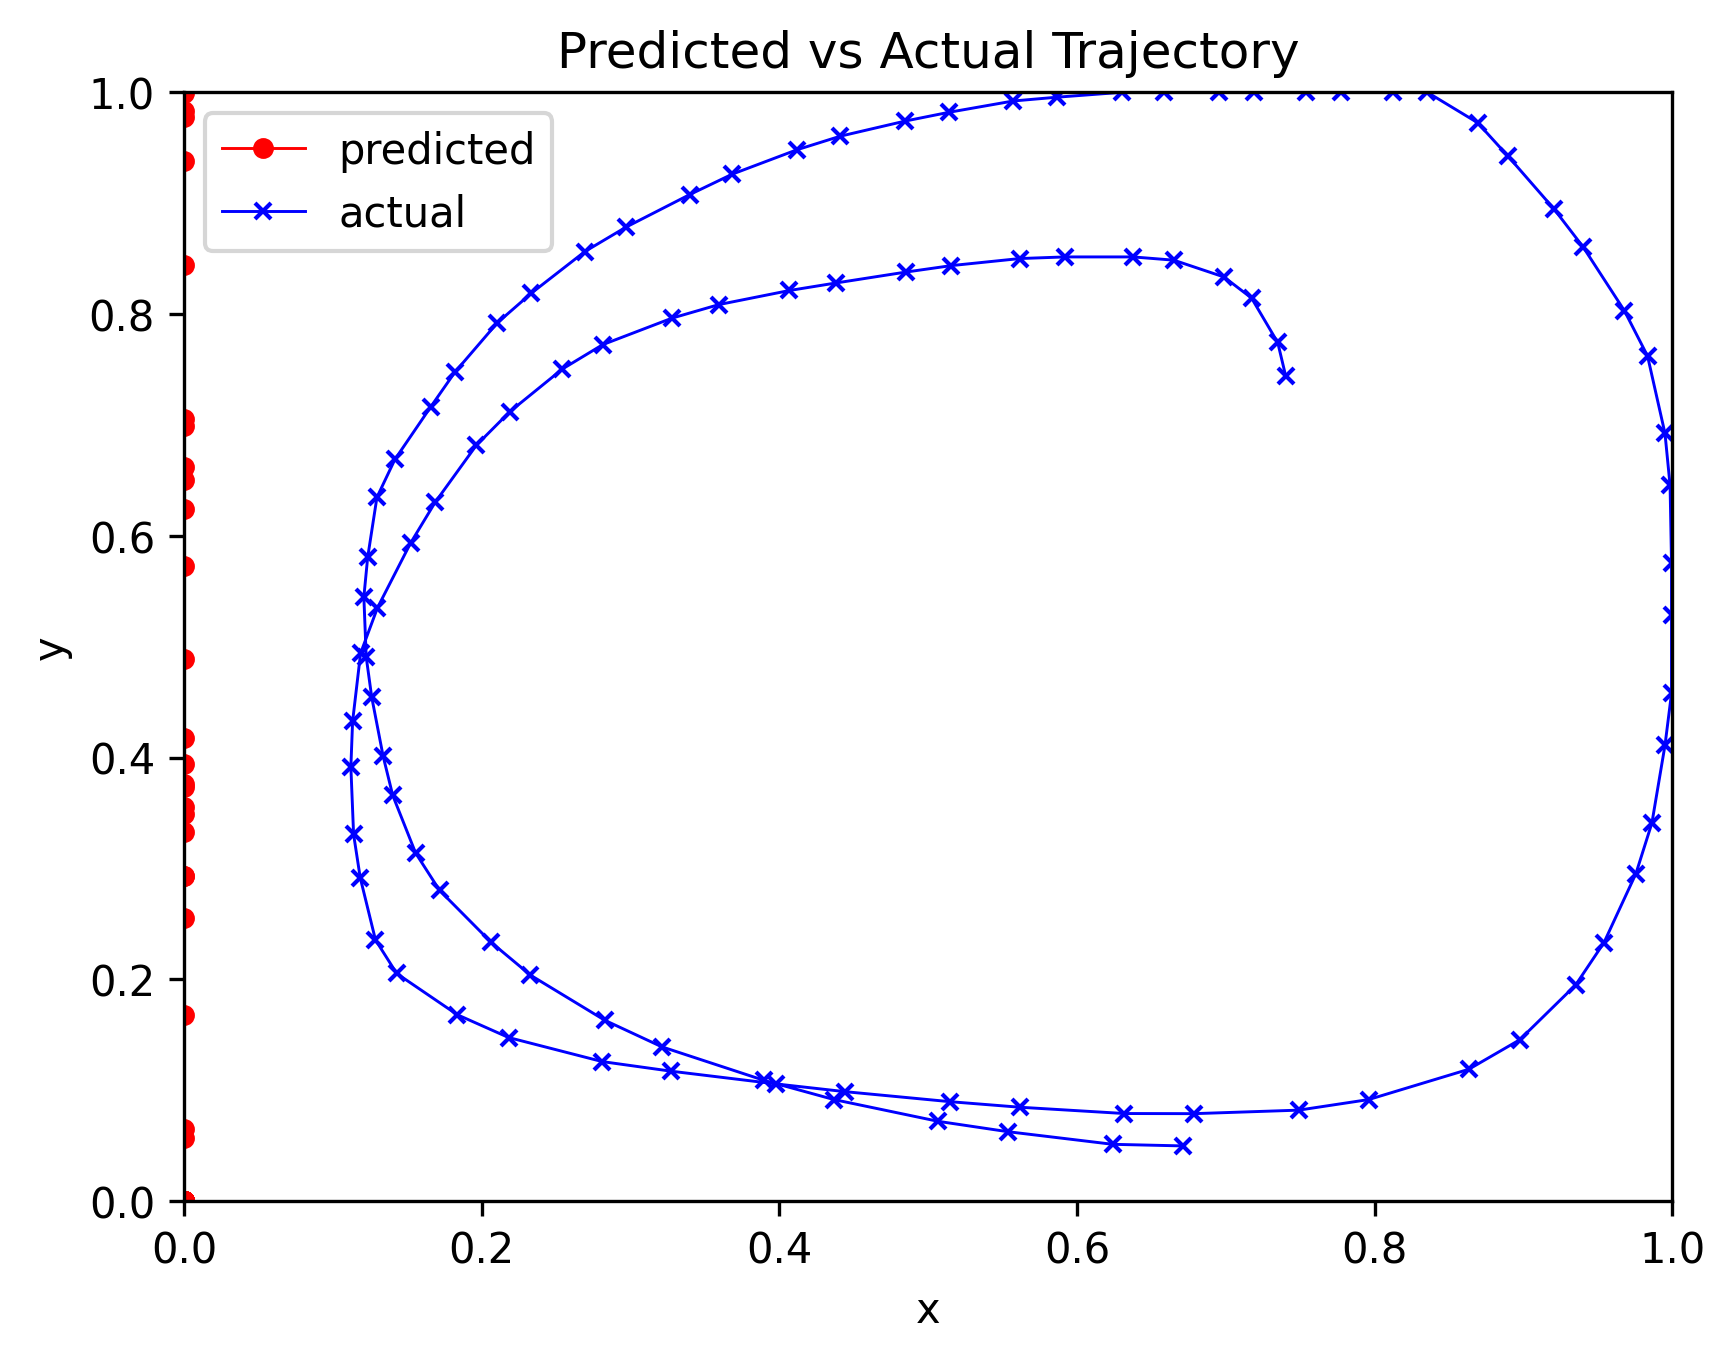

0.0


In [33]:
import matplotlib.pyplot as plt
# from matplotlib import rc,rcParams
# rc('text', usetex=True)
# rc('font', weight='bold')
# custom_preamble = {
#     "text.latex.preamble":
#         r"\usepackage{amsmath,amssymb}" # for the align, center,... environment
#         ,
#     }
# plt.rcParams.update(custom_preamble)
#select n consecutive images and plot the actual and predicted trajectories:
n = 100
start = 33
def eval_plot(data, net):
    with torch.no_grad():
        #computes the forward pass and loss of the loaded_data
        inputs = torch.Tensor(data[0])  # Unpack the inputs and labels from the data loader
        # print(inputs, labels)
        # forward + backward + optimize
        outputs = net(inputs.unsqueeze(0).unsqueeze(0))
    return outputs[0].numpy()

selected_data = snipped_data[start:start+n]
predicted_labels = [eval_plot(data, net) for data in selected_data]
actual_labels = [data[1] for data in selected_data]
diff = [np.linalg.norm(predicted_labels[i] - actual_labels[i]) for i in range(len(predicted_labels))]
print("Average difference between predicted and actual labels: ", np.mean(diff))
fig, ax = plt.subplots(dpi=300)
ms = 4
ax.plot([predicted_labels[i][0] for i in range(len(predicted_labels))],[predicted_labels[i][1] for i in range(len(predicted_labels))], label="predicted", color="red",lw=0.7, marker='o', markersize=ms)
print([predicted_labels[i][1] for i in range(len(predicted_labels))])
ax.plot([actual_labels[i][0] for i in range(len(actual_labels))],[actual_labels[i][1] for i in range(len(actual_labels))], label="actual", color="blue",lw=0.7, marker='x', markersize=ms)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_title("Predicted vs Actual Trajectory")
ax.legend()
plt.show()
diff = [np.linalg.norm(predicted_labels[i] - actual_labels[i]) for i in range(len(predicted_labels))]
precentages = len(np.where(np.array(diff) < 0.1)[0])/len(diff)
print(precentages)

In [20]:
print(net)

EEGNet(
  (conv1): Conv2d(1, 16, kernel_size=(60, 1), stride=(1, 1))
  (batchnorm1): BatchNorm2d(16, eps=False, momentum=0.1, affine=True, track_running_stats=True)
  (padding1): ZeroPad2d((0, 0, 0, 0))
  (conv2): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2): BatchNorm2d(4, eps=False, momentum=0.1, affine=True, track_running_stats=True)
  (pooling2): MaxPool2d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (padding2): ZeroPad2d((0, 0, 0, 0))
  (conv3): Conv2d(4, 4, kernel_size=(2, 2), stride=(1, 1))
  (batchnorm3): BatchNorm2d(4, eps=False, momentum=0.1, affine=True, track_running_stats=True)
  (pooling3): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=248, out_features=2, bias=True)
)


In [21]:
weight_fc1 = net.fc1.weight
weight_max = torch.max(weight_fc1)
print(weight_max)
weight_min = torch.min(weight_fc1)
print(weight_min)

tensor(0.0635, grad_fn=<MaxBackward1>)
tensor(-0.0634, grad_fn=<MinBackward1>)


In [22]:
fig.savefig('CNN_fp_relu.png', dpi = 150)

In [23]:
# Create an instance of EEGNet
num_electrodes = 60
im_len = 1000
model = EEGNet(num_electrodes, im_len)

# Calculate the total number of tunable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of tunable parameters:", total_params)

Total number of tunable parameters: 1132


In [24]:
# batch_size = 128
# train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
# net = EEGNet(num_electrodes, im_len).cpu()
# criterion = nn.MSELoss()
# optimizer = optim.Adam(net.parameters())
# epoch_size = 50
# epoch_loss = []
# n_batches = len(train_loader)
# for epoch in range(epoch_size):
#     print("\nEpoch -", epoch)
    
#     running_loss = 0.0
#     for i, data in enumerate(train_loader, 0):  # Use the train_loader for data loading
        
#         inputs, labels = data  # Unpack the inputs and labels from the data loader
#         # inputs = [input for input in inputs]
#         # labels = [label for label in labels]
#         # print('shape of the batch_inputs', inputs.shape)
#         # wrap them in Variable (not necessary in recent versions of PyTorch)
#         # inputs, labels = Variable(inputs.cuda(0)), Variable(labels.cuda(0))

#         # zero the parameter gradients
#         optimizer.zero_grad()
#         l = torch.cat((labels[0], labels[1]))
#         l = l.reshape(len(labels[0]), 2)
#         # forward + backward + optimize
#         outputs = net(inputs.unsqueeze(1))
        
#         loss = criterion(outputs, l)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()  # Use loss.item() to get the scalar value of the loss
# #         # correlation
# #         x_data = torch.cat((outputs[:,0],l[:,0]))
# #         x_data = x_data.reshape(2,len(outputs[:,0]))
# #         corr_x = torch.corrcoef(x_data)
# #         y_data = torch.cat((outputs[:,1],l[:,1]))
# #         y_data = y_data.reshape(2,len(outputs[:,1]))
# #         corr_y = torch.corrcoef(y_data)

# #         print('Batch number: ', i, 'Loss: ', loss.item())
# #         print('Pearsons correlation for x: %.3f' % corr_x[0,1])
# #         print('Pearsons correlation for y: %.3f' % corr_y[0,1])
        
# #         print('Batch number: ', i, 'Loss: ', loss.item())
#     print("Epoch {} - Loss: {:.4f}".format(epoch, running_loss / n_batches))
#     epoch_loss.append(running_loss / n_batches)


In [25]:
diff = [np.linalg.norm(predicted_labels[i] - actual_labels[i]) for i in range(len(predicted_labels))]
precentages = len(np.where(np.array(diff) < 0.1)[0])/len(diff)

In [26]:
precentages

0.0

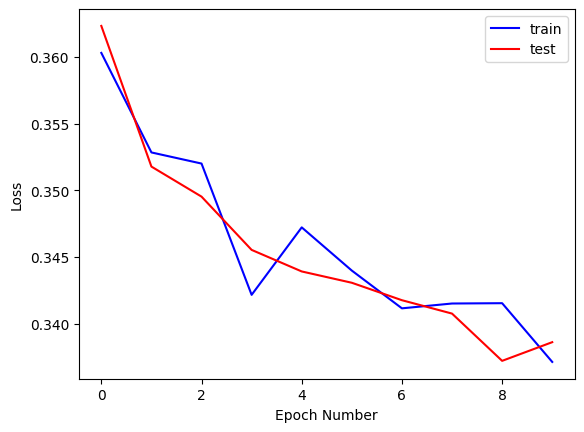

In [27]:
# plot the loss 
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(train_loss_all, label="train", color="blue")
ax.plot(test_loss_all, label="test", color="red")
ax.set_xlabel('Epoch Number')
ax.set_ylabel('Loss')
ax.legend()

fig.savefig('CNN_loss_relu.png', dpi = 150)
# calculate accuracy
# activation function: 0 to 1 (since we normalized the location and the values should be frmo 0 to 1.

In [28]:
torch.save(net.state_dict(), 'trained_net')

In [29]:
# def evaluate(model, X, Y, params = ["acc"]):
#     results = []
#     batch_size = 128
    
#     predicted = []
    
#     for i in range(len(X)/batch_size):
#         s = i*batch_size
#         e = i*batch_size+batch_size
        
#         inputs = Variable(torch.from_numpy(X[s:e]).cuda(0))
#         pred = model(inputs)
        
#         predicted.append(pred.data.cpu().numpy())
        
        
#     inputs = Variable(torch.from_numpy(X).cuda(0))
#     predicted = model(inputs)
    
#     predicted = predicted.data.cpu().numpy()
    
#     for param in params:
#         if param == 'acc':
#             results.append(accuracy_score(Y, np.round(predicted)))
#         if param == "auc":
#             results.append(roc_auc_score(Y, predicted))
#         if param == "recall":
#             results.append(recall_score(Y, np.round(predicted)))
#         if param == "precision":
#             results.append(precision_score(Y, np.round(predicted)))
#         if param == "fmeasure":
#             precision = precision_score(Y, np.round(predicted))
#             recall = recall_score(Y, np.round(predicted))
#             results.append(2*precision*recall/ (precision+recall))
#     return results